# PyTorch로 MNIST 손글씨 숫자 분류 실험

MNIST 손글씨 숫자 데이터셋을 분류하는 모델을 구현하고 학습한 뒤 결과 분석

- 테스트 정확도 측정
    - 테스트셋으로 정확도 계산 및 출력
- 혼동행렬 및 오분류 시각화
    - sklearn.metrics.confusion_matrix를 이용해 혼동행렬 출력

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

In [2]:
# datasetsMNIST를 이용하여 바로 mnist 데이터 셋을 가져올 수 있습니다 !!
mnist_dataset = datasets.MNIST('dataset', train=True, download=True,
               transform=transforms.Compose([
                   transforms.ToTensor()

]))
mnist_dataset

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 507kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.09MB/s]


Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),                   # [0,255] 픽셀값 → [0.0,1.0] Tensor
    transforms.Normalize(                    # 평균/표준편차로 표준화
        (0.1307,),   # MNIST 전체 train set의 픽셀 평균
        (0.3081,)    # MNIST 전체 train set의 픽셀 표준편차
    )
])

In [4]:
# 3) 데이터 로더 준비
train_ds = datasets.MNIST(
    root='./data',        # 데이터 저장/로드 경로
    train=True,           # 학습용 데이터 사용
    download=True,        # 없으면 인터넷에서 받아오기
    transform=transform   # 위에서 정의한 전처리 적용
)
test_ds = datasets.MNIST(
    root='./data',
    train=False,          # 테스트용 데이터 사용
    download=True,
    transform=transform
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 502kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.73MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.22MB/s]


In [5]:
# 배치 사이즈 64, 학습 시 셔플
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
# 테스트는 셔플 False (결과 재현성 위해)
test_loader  = DataLoader(test_ds,  batch_size=1000, shuffle=False)

In [6]:
# 4) 모델 정의: 간단한 2-층 MLP (Fully Connected)
class MNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 입력: 28×28=784 → 은닉층 뉴런 256개
        self.fc1 = nn.Linear(28*28, 256)
        # 활성화 함수
        self.relu = nn.ReLU()
        # 은닉층(256) → 출력층(10 클래스)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # 입력 x: (batch_size, 1, 28, 28) 형태
        x = x.view(-1, 28*28)      # → (batch_size, 784)로 펼치기
        x = self.fc1(x)            # 완전연결 1
        x = self.relu(x)           # ReLU 활성화
        x = self.fc2(x)            # 완전연결 2 → 로짓(logits) 반환
        return x


In [7]:
# 5) 디바이스 설정: GPU(cuda) 사용 가능 시 우선 사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MNISTNet().to(device)   # 모델을 GPU/CPU로 이동

criterion = nn.CrossEntropyLoss()      # 소프트맥스 + 크로스엔트로피
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer, lr=0.001

In [8]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()                      # 학습 모드로 전환 (드롭아웃 등 활성화)
    total_loss = 0.0
    for images, labels in loader:
        # 미니배치 데이터를 디바이스(GPU/CPU)로 이동
        images, labels = images.to(device), labels.to(device)

        # 1) 기울기 초기화
        optimizer.zero_grad()
        # 2) 순전파 → 로짓 계산
        outputs = model(images)
        # 3) 손실 계산
        loss = criterion(outputs, labels)
        # 4) 역전파
        loss.backward()
        # 5) 가중치 업데이트
        optimizer.step()

        # 배치 손실 합산
        total_loss += loss.item() * images.size(0)
    # 평균 손실 반환
    return total_loss / len(loader.dataset)

In [9]:
# 8) 평가 함수 정의 (정확도 + 예측/실제 값 반환)
def evaluate(model, loader):
    model.eval()                       # 평가 모드로 전환 (드롭아웃 등 비활성)
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():              # 기울기 계산 비활성
        for images, labels in loader:
            images = images.to(device)
            logits = model(images)     # 예측 로짓
            preds = logits.argmax(dim=1).cpu().numpy()  # 가장 높은 값 클래스 추출
            all_preds.append(preds)
            all_labels.append(labels.numpy())
            # 정확도 누적
            correct += (preds == labels.numpy()).sum()
    accuracy = correct / len(loader.dataset)
    # 전체 예측/실제 값 배열로 결합
    return accuracy, np.concatenate(all_preds), np.concatenate(all_labels)

In [10]:
# 9) 모델 학습 루프
num_epochs = 5
for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    train_acc, _, _ = evaluate(model, train_loader)
    print(f"[Epoch {epoch:2d}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")


[Epoch  1] Train Loss: 0.2272, Train Acc: 0.9714
[Epoch  2] Train Loss: 0.0959, Train Acc: 0.9803
[Epoch  3] Train Loss: 0.0660, Train Acc: 0.9874
[Epoch  4] Train Loss: 0.0481, Train Acc: 0.9896
[Epoch  5] Train Loss: 0.0382, Train Acc: 0.9898


In [12]:
# 10) 테스트 정확도 측정
test_acc, test_preds, test_labels = evaluate(model, test_loader)
print(f"\n▶ Test Accuracy: {test_acc:.4f}")


▶ Test Accuracy: 0.9772


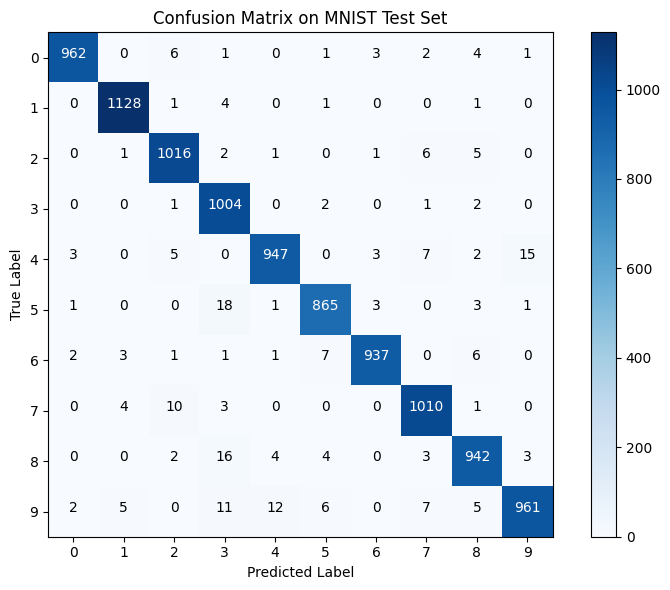

In [13]:
# 11) 혼동행렬(confusion matrix) 계산 및 시각화
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix on MNIST Test Set")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# 셀마다 숫자 표시
thresh = cm.max() / 2.
for i in range(10):
    for j in range(10):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

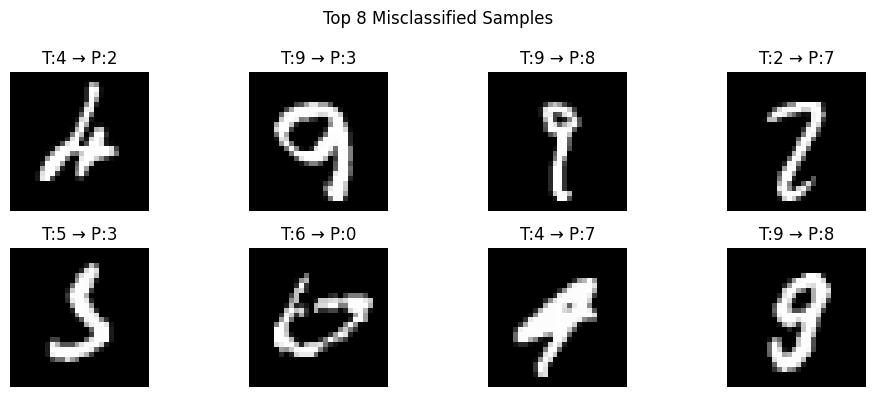

In [14]:
# 12) 오분류 샘플 시각화: 상위 8개
mis_idx = np.where(test_preds != test_labels)[0]
plt.figure(figsize=(10,4))
for i, idx in enumerate(mis_idx[:8]):
    img, true_label = test_ds[idx]
    pred_label = test_preds[idx]
    plt.subplot(2, 4, i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"T:{true_label} → P:{pred_label}")
    plt.axis('off')
plt.suptitle("Top 8 Misclassified Samples")
plt.tight_layout()
plt.show()

# 결론

## 1. 학습과정 요약
- 수렴 속도 : 3~4 epoch만에 거의 수렴했으며, 추가 학습에서도 큰 개선폭은 없었음.
- 과적합 여부 : 약 1.2% 차이로 경미한 과적합 발생, 하지만 일반화 성능은 양호함

## 2. 테스트 성능
- class별 Recall
    - 최우수 : 1 클래스
    - 최저 : 4 클래스

## 3. 혼동행렬 분석
- 주요 오분류 패턴  
    - '5 ↔ 3’: 5→3 (18건), 3→5 (2건)

    - ‘4 ↔ 9’: 4→9 (15건), 9→4 (12건)

    - ‘7 ↔ 2’: 7→2 (10건), 2→7 (0건)

    - ‘9 ↔ 8’, ‘9 ↔ 3’: 9→8 (11건), 9→3 (11건)

## 4. 개선 방안

1. 모델 구조 강화
    - 현재 MLP에서 간단한 CNN 적용 시 지역적 특징 학습으로 성능 up
    
2. 오분류 집중 분석
    - 혼동행렬 상위 2~3개 교차 쌍을 별도로 추출해서 해당 샘플만 모아서 추가 학습
    - 손글씨 형태별 클러스터링 후 클러스터별 전문 분류기 앙상블

# 추가 학습 : Precision/Recall/F1 계산+분석 해보기

### Precision/Recall/F1-score를 함께 보면 모델의 성능을 더 세밀하게 평가할 수 있지 않을까?

1. 클래스별 상세 성능 파악
- 정확도는 전체적으로 몇 퍼센트 맞췄는지만 알려준다.
- 반면 precision/Recall은 특정 클래스에서
    - 얼마나 정확히(Precision) 예측했는지,
    - 얼마나 빠짐없이 (Recall) 잡아냈는지를 분리해서 보여준다.
2. 과대 예측 vs 과소 예측 진단
- 모델이 어떤 클래스를 과하게 또는 부족하게 예측하는 지 알 수 있다.
- 실제 4는 잘 맞히지만, 4로 잘못 예측 되는 (Precision 낮음) 숫자가 많은지, 또는 실제 4중 놓치는 (Recall 낮음) 숫자가 많은 지 구분 가능하다.
=> 이걸 통해서 Precision이 낮은 클래스는 과대 예측, Recall이 낮은 클래스는 과소 예측 대상임을 바로 알 수 있음
=> 경우에 맞는 모델 튜닝을 할 수 있다!

3. 불균형 대응 및 중요 클래스 집중
- MNIST는 균등 분포지만, 실제 응용에선 특정 클래스 혼동 비용이 다를 수 있음.
- Precision/Recall 기반으로 손실함수에 가중치를 주거나 샘플링 전략을 세울 때 근거가 된다.

4. F1-score로 종합적 평가
- Precision과 Recall 간의 트레이드 오프를 하나의 지표로 요약해줘.
- 하이퍼파라미터 튜닝 시 "균형있게" 성능이 올라갔는 지 확인할 수 있다!



In [15]:
# MNIST 분류 모델에 대한 Precision / Recall / F1-score 계산 및 출력

# (2) 모델을 평가 모드로 전환하고, 모든 테스트 샘플에 대해 예측을 수행
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images)                        # 로짓(logits) 계산
        preds = logits.argmax(dim=1).cpu().numpy()    # 가장 높은 확률 클래스 선택
        all_preds.append(preds)
        all_labels.append(labels.numpy())


In [16]:
# 넘파이 배열로 합치기
test_preds  = np.concatenate(all_preds)
test_labels = np.concatenate(all_labels)

In [17]:
# (3) 혼동행렬 출력 (옵션)
cm = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[ 962    0    6    1    0    1    3    2    4    1]
 [   0 1128    1    4    0    1    0    0    1    0]
 [   0    1 1016    2    1    0    1    6    5    0]
 [   0    0    1 1004    0    2    0    1    2    0]
 [   3    0    5    0  947    0    3    7    2   15]
 [   1    0    0   18    1  865    3    0    3    1]
 [   2    3    1    1    1    7  937    0    6    0]
 [   0    4   10    3    0    0    0 1010    1    0]
 [   0    0    2   16    4    4    0    3  942    3]
 [   2    5    0   11   12    6    0    7    5  961]]


In [19]:
# (4) Classification Report 출력
#     — precision, recall, f1-score, support(샘플 수)를 클래스별로 보여줌

from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(
    test_labels,      # 실제 레이블 배열 (shape: [N])
    test_preds,       # 예측 레이블 배열 (shape: [N])
    digits=4          # 소수점 4자리까지 포맷팅
)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0     0.9918    0.9816    0.9867       980
           1     0.9886    0.9938    0.9912      1135
           2     0.9750    0.9845    0.9797      1032
           3     0.9472    0.9941    0.9700      1010
           4     0.9803    0.9644    0.9723       982
           5     0.9763    0.9697    0.9730       892
           6     0.9894    0.9781    0.9837       958
           7     0.9749    0.9825    0.9787      1028
           8     0.9701    0.9671    0.9686       974
           9     0.9796    0.9524    0.9658      1009

    accuracy                         0.9772     10000
   macro avg     0.9773    0.9768    0.9770     10000
weighted avg     0.9774    0.9772    0.9772     10000



### Classification Report 해석

* "3" : Precision이 낮음 : 다른 숫자를 3으로 잘못 예측한 빈도가 높음 (=모델이 다른 숫자를 3으로 잘못 찍는 케이스가 상대적으로 많음)  
* "4", "9" : Recall이 낮음 : 실제 4를 놓치는 경우가 다소 존재함. (=실제 4, 9를 다른 숫자로 오분류 하는 샘플이 눈에 띈다)

> 3은 과대 예측, 4,9는 과소예측 문제가 있다는 점을 알 수 있음.